In [1]:
# Code calculates month-wise mean of R0 from 2007 to 2023
# plots each month with consecutive month overlayed on the previous month
# import packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# load data file
ds = xr.open_dataset('chikv_europe_event.nc')

In [3]:
# take month-wise average of the dataset
ds_months = ds.groupby('time.month').mean()
ds_month_vals = ds_months['R0eve'].values

In [4]:
# check dimensions
[np.shape(ds_month_vals), ds_months.dims]

[(12, 372, 442),
 FrozenMappingWarningOnValuesAccess({'latitude': 372, 'longitude': 442, 'month': 12})]

In [5]:
# convert month probabilities to event:  1 for P(R0 > 1) > 0.95 and 0 for ~ (P(R0 > 1) > 0.95)
month_event = np.where(~np.isnan(ds_month_vals), np.where(ds_month_vals > 0.95, 1, 0), np.nan)

# write dataset
# setting dimensions and coordinates of the dataset
dims = ['month', 'latitude', 'longitude']
coords = {
    'month': ds_months['month'].values,
    'latitude': ds_months['latitude'].values,
    'longitude': ds_months['longitude'].values
}
da_month_event = xr.DataArray(data=month_event, dims=dims, coords=coords)

# get the dataset
ds_month_event = xr.Dataset({'R0eve': da_month_event})

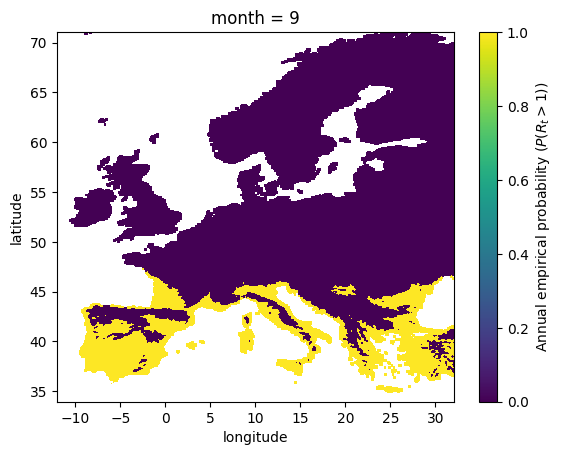

In [6]:
# plotting each year data
plot = ds_month_event['R0eve'].isel(month=8).plot()
cbar = plot.colorbar
cbar.set_label(r'Annual empirical probability ($P(R_{t} > 1)$)')
#plt.title('Year 2023')
#plt.savefig('plots/dengue_annual_2023.png')

In [7]:
# counting the locations which has consecutive risk from one month to another
ds_upto_jan = ds_month_event['R0eve'].isel(month=0)
ds_upto_feb = ds_month_event['R0eve'].isel(month=0) + ds_month_event['R0eve'].isel(month=1)
ds_upto_mar = ds_upto_feb + ds_month_event['R0eve'].isel(month=2)
ds_upto_apr = ds_upto_mar + ds_month_event['R0eve'].isel(month=3)
ds_upto_may = ds_upto_apr + ds_month_event['R0eve'].isel(month=4)
ds_upto_jun = ds_upto_may + ds_month_event['R0eve'].isel(month=5)
ds_upto_jul = ds_upto_jun + ds_month_event['R0eve'].isel(month=6)
ds_upto_aug = ds_upto_jul + ds_month_event['R0eve'].isel(month=7)
ds_upto_sep = ds_upto_aug + ds_month_event['R0eve'].isel(month=8)
ds_upto_oct = ds_upto_sep + ds_month_event['R0eve'].isel(month=9)
ds_upto_nov = ds_upto_oct + ds_month_event['R0eve'].isel(month=10)
ds_upto_dec = ds_upto_nov + ds_month_event['R0eve'].isel(month=11)

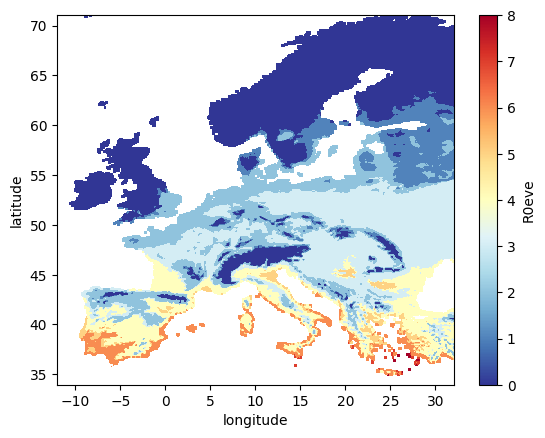

In [16]:
# round the values to keep integer numbers only
ds_upto_dec_round = ds_upto_dec.round()
ds_upto_dec_round.plot(cmap='RdYlBu_r')

In [14]:
# Adding shape boundaries using Eurostat NUTS level 0 and level 3 boundaries
# use package geopandas
# the nuts shape file
path_sf = "sf_nuts_2021/NUTS_RG_03M_2021_4326.shp"
sf_2021 = gpd.read_file(path_sf, encoding='latin1')
sf_lvl_0 = sf_2021[sf_2021['LEVL_CODE'] == 0] # level 0
sf_lvl_3 = sf_2021[sf_2021['LEVL_CODE'] == 3] # level 3

# check the CRS (EPSG: 4326): level 0
if sf_lvl_0.crs != "EPSG:4326":
    sf_lvl_0 = sf_lvl_0.to_crs("EPSG: 4326")

# check the CRS (EPSG: 4326): level 3
if sf_lvl_3.crs != "EPSG:4326":
    sf_lvl_3 = sf_lvl_3.to_crs("EPSG: 4326")

# ensure that netcdf has correct crs
if not ds_upto_dec_round.rio.crs:
    ds_upto_dec_round = ds_upto_dec_round.rio.write_crs("EPSG: 4326")

# clip the shape file boundaries: level 0
sf_clipped_0 = ds_upto_dec_round.rio.clip(sf_lvl_0.geometry, all_touched=True, drop=True)

# clip the shape file boundaries: level 3
sf_clipped_3 = ds_upto_dec_round.rio.clip(sf_lvl_3.geometry, all_touched=True, drop=True)

# load the ocean shapefile
ocean = gpd.read_file("sf_naturalearth/ne_50m_ocean.shp")

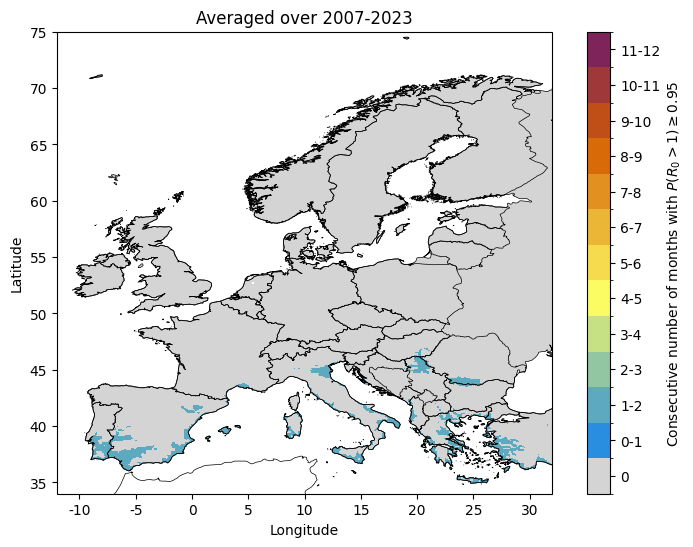

In [15]:
# add ocean boundaries
# final version

# designing cmaps
# Define a colorblind-friendly color scheme
clrs = ['#1E88E5', '#FEFE62', '#D55E00', '#4B0092']  # Colorblind-friendly colors
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', clrs, N=65)

# Define boundary and color binning
light_gray = np.array([0.83, 0.83, 0.83, 1])
colours = [light_gray] + [custom_cmap(i/65) for i in range(1, 61, 5)]
new_cmap = ListedColormap(colours)

# Set boundaries for color bins and labels for color bar
bounds = [0, 0.0333, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
norm = BoundaryNorm(bounds, new_cmap.N)
midpoints = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds) - 1)]
labels = ['0'] + ['0-1'] + [f'{bounds[i]}-{bounds[i+1]}' for i in range(2, len(bounds) - 1)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with custom color map
pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds_upto_dec_round,
                    cmap=new_cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree())

# Add level 0 boundaries and ocean boundaries
sf_lvl_0.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=1)
ocean.plot(ax=ax, color='white', edgecolor='none', transform=ccrs.PlateCarree())

# Add coastlines
ax.coastlines(resolution='50m', color='black', linewidth=0.5)

# Create color bar with labels
cbar = plt.colorbar(pcm, ticks=midpoints)
cbar.set_label(r'Consecutive number of months with $P(R_{0} > 1)\geq 0.95$')
cbar.set_ticklabels(labels)

# Set axis limits for longitude (x-axis) and latitude (y-axis)
ax.set_extent([-12, 32, 34, 75], crs=ccrs.PlateCarree())
ax.set_xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], crs=ccrs.PlateCarree())
ax.set_yticks([35, 40, 45, 50, 55, 60, 65, 70, 75], crs=ccrs.PlateCarree())
ax.set_xticklabels([-10, -5, 0, 5, 10, 15, 20, 25, 30])
ax.set_yticklabels([35, 40, 45, 50, 55, 60, 65, 70, 75])

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Averaged over 2007-2023')

# Save and show plot
#plt.savefig('plots/chikv_consecutive_months.png', dpi=600)
plt.show()

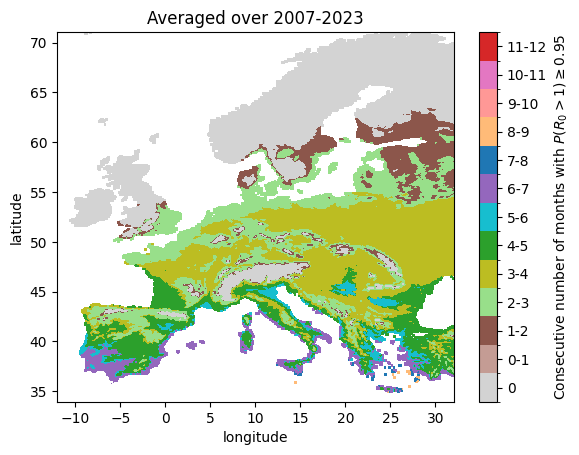

In [10]:
# extra: 1
# prefinal version
# binning months: call BoundaryNorm and ListedColormap functions

# choosing colours manually
lightgray = np.array([0.83, 0.83, 0.83, 1])
colours = ['lightgray'] + ['#C49C94'] + ['#8C564B'] + ['#98DF8A'] + ['#BCBD22'] + ['#2CA02C'] + ['#17BECF'] + ['#9467BD'] + ['#1F77B4'] + ['#FFBB78'] + ['#FF9896'] + ['#E377C2'] + ['#FF7F0E'] + ['#D62728']
lightgray = np.array([0.83, 0.83, 0.83, 1])
new_cmap = ListedColormap(colours)
bounds = [0, 0.0333, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
norm = BoundaryNorm(bounds, new_cmap.N)
midpoints = [(bounds[i] + bounds[i+1])/2 for i in range(len(bounds) - 1)]
labels = ['0'] + ['0-1'] + [f'{bounds[i]}-{bounds[i+1]}' for i in range(2, len(bounds) - 1)]

pcm = plt.pcolormesh(ds['longitude'], ds['latitude'],ds_upto_dec_round, cmap=new_cmap, norm=norm, shading = 'auto')

cbar = plt.colorbar(pcm, ticks=midpoints)
cbar.set_label(r'Consecutive number of months with $P(R_{0} > 1)\geq 0.95$')
cbar.set_ticklabels(labels)

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Averaged over 2007-2023')
#plt.savefig('plots/chikv_consecutive_months.png', dpi=300)
plt.show()

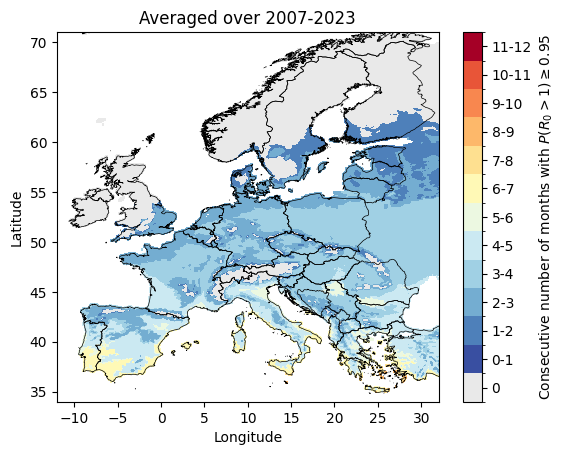

In [10]:
#extra: 2
# final version
# binning months: call BoundaryNorm and ListedColormap functions
# choosing colours manually
light_gray = np.array([0.83, 0.83, 0.83, 1])
cmap_scale = plt.get_cmap('RdYlBu_r', 26)
colour_scale = cmap_scale(np.linspace(0, 1, 26))
odd_scale = colour_scale[1::2]
colours = np.vstack((np.array([0.83, 0.83, 0.83, 0.5]), odd_scale))
new_cmap = ListedColormap(colours)
bounds = [0, 0.0333, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
norm = BoundaryNorm(bounds, new_cmap.N)
midpoints = [(bounds[i] + bounds[i+1])/2 for i in range(len(bounds) - 1)]
labels = ['0'] + ['0-1'] + [f'{bounds[i]}-{bounds[i+1]}' for i in range(2, len(bounds) - 1)]

# Create the figure and axis
fig, ax = plt.subplots()

pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds_upto_dec_round, cmap=new_cmap, norm=norm, shading = 'auto')
# Add the level 0 (NUTS level 0) boundaries
sf_lvl_0.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=1)

cbar = plt.colorbar(pcm, ticks=midpoints)
cbar.set_label(r'Consecutive number of months with $P(R_{0} > 1)\geq 0.95$')
cbar.set_ticklabels(labels)

# Set axis limits for longitude (x-axis) and latitude (y-axis)
ax.set_xlim([-12, 32])
ax.set_ylim([34, 71])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Averaged over 2007-2023')
#plt.savefig('plots/chikv_consecutive_months.pdf', dpi=300)
plt.show()

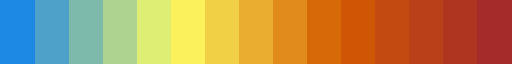

In [18]:
# designing cmaps
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
#clrs = ['#1E88E5', '#FFC107','#004D40']
clrs = ['#1E88E5', '#FEFE62', '#D55E00', '#4B0092'] 
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', clrs, N=15)
custom_cmap